In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import pandas as pd
import subprocess
import matplotlib.pyplot as plt
from itertools import combinations
from networkx import write_gpickle as write_g
import networkx as nx

In [23]:
plays_df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Shakespeare Network Analyses/Shakespeare_data.csv")
# Drop stage directions (where there isn't an act/scene/line)
plays_df = plays_df[pd.notna(plays_df['ActSceneLine'])]
plays_df[['Act','Scene','Line']] = plays_df['ActSceneLine'].str.split('.',expand = True).astype(float)
plays_df = plays_df.drop('ActSceneLine',axis=1)
# Drop Shakespeare's histories
tragedies = ["Hamlet","macbeth", "Othello"]
plays_df = plays_df[plays_df["Play"].isin(tragedies)]
print("{} rows and {} columns".format(*plays_df.shape))
plays_df.head()

9973 rows and 8 columns


,Dataline,Play,PlayerLinenumber,Player,PlayerLine,Act,Scene,Line
32435,32436,Hamlet,1.0,BERNARDO,Who's there?,1.0,1.0,1.0
32436,32437,Hamlet,2.0,FRANCISCO,"Nay, answer me: stand, and unfold yourself.",1.0,1.0,2.0
32437,32438,Hamlet,3.0,BERNARDO,Long live the king!,1.0,1.0,3.0
32438,32439,Hamlet,4.0,FRANCISCO,Bernardo?,1.0,1.0,4.0
32439,32440,Hamlet,5.0,BERNARDO,He.,1.0,1.0,5.0


In [24]:
play_name = "Hamlet"
single_play = plays_df[(plays_df['Play'] == play_name)]
# Group the df by character to get how often each speak
characters = single_play.groupby(['Player']).size().reset_index()
characters.rename(columns = {0: 'Count'}, inplace = True)
# Get top 20 characters
characters = characters[characters["Count"] > 5]

In [25]:
characters = characters["Player"]

In [26]:
characters

1              BERNARDO
2               Captain
4             FRANCISCO
5      First Ambassador
6           First Clown
7          First Player
8          First Priest
10         GUILDENSTERN
11            Gentleman
12                Ghost
13               HAMLET
14              HORATIO
15        KING CLAUDIUS
16              LAERTES
17        LORD POLONIUS
18             LUCIANUS
19                 Lord
20            MARCELLUS
22              OPHELIA
23                OSRIC
24    PRINCE FORTINBRAS
25          Player King
26         Player Queen
28       QUEEN GERTRUDE
29             REYNALDO
30          ROSENCRANTZ
31         Second Clown
33            VOLTIMAND
Name: Player, dtype: object

In [27]:
#characters = characters.drop(labels=[20,21])

In [28]:
def graphify(characters):
  play_graph = nx.Graph()
  play_graph.add_nodes_from(characters)
  scenes_df = single_play.groupby(['Act','Scene','Player']).size()
  scenes_df = scenes_df.loc[:,:,characters]
  for (act,scene), counts in scenes_df.groupby(['Act','Scene']):
    chars = counts.index.get_level_values(2).tolist()
    pairs = list(combinations(chars,2))
    for (a_char, b_char) in pairs:
        if play_graph.has_edge(a_char, b_char):
            play_graph[a_char][b_char]['weight'] += 1
        else:
            play_graph.add_edge(a_char, b_char,weight=1)
  return play_graph

In [29]:
G_weighted = graphify(characters)

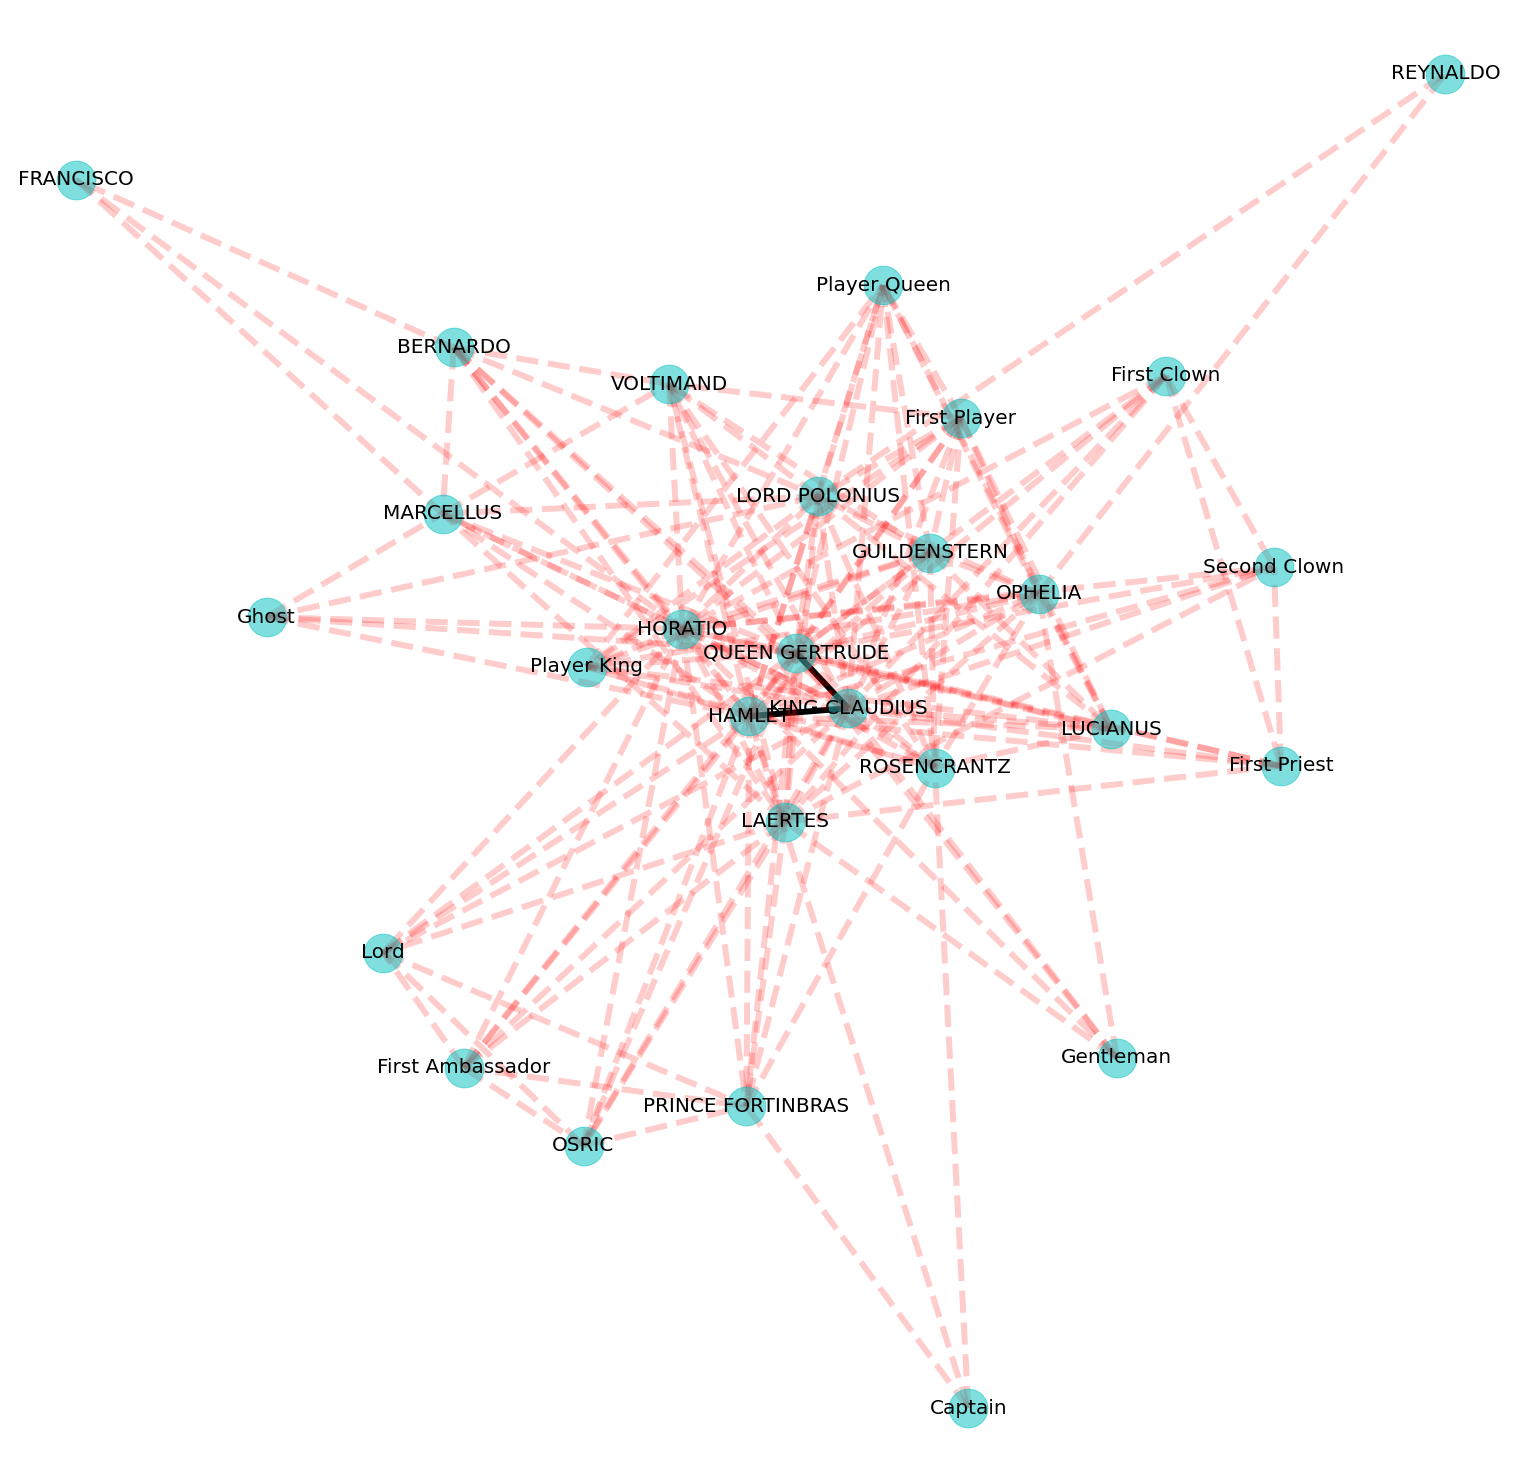

In [35]:
elarge = [(u, v) for (u, v, d) in G_weighted.edges(data=True) if d['weight'] > 7]
esmall = [(u, v) for (u, v, d) in G_weighted.edges(data=True) if d['weight'] <= 7]

pos = nx.spring_layout(G_weighted)

plt.figure(figsize=(27,27)) 
# nodes
nx.draw_networkx_nodes(G_weighted, pos, alpha=0.5, node_color='c', node_size=1500)

# edges
nx.draw_networkx_edges(G_weighted, pos, edgelist=elarge,width=6)
nx.draw_networkx_edges(G_weighted, pos, edgelist=esmall,width=6, alpha=0.2, edge_color='r', style='dashed')

# labels
nx.draw_networkx_labels(G_weighted, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show();